<a href="https://colab.research.google.com/github/MostafaJahanian/Free_Projects/blob/main/alzheimer_brain_images_classification_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Data From Kaggle

In [2]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images

 94% 32.0M/34.1M [00:00<00:00, 98.1MB/s]
100% 34.1M/34.1M [00:00<00:00, 96.8MB/s]


In [ ]:
! unzip alzheimers-dataset-4-class-of-images.zip

## Create Datasets From Images

In [7]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import random
import pathlib
import cv2

In [8]:
train_dir = pathlib.Path('/content/Alzheimer_s Dataset/train')
test_dir = pathlib.Path('/content/Alzheimer_s Dataset/test')
train_dir, test_dir

(PosixPath('/content/Alzheimer_s Dataset/train'),
 PosixPath('/content/Alzheimer_s Dataset/test'))

In [9]:
class_names = keras.utils.image_dataset_from_directory('/content/Alzheimer_s Dataset/train').class_names
class_names

Found 5121 files belonging to 4 classes.


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [10]:
train_images_dir = []
for label in class_names:
  train_images_dir.append(list(train_dir.glob(f'{label}/*')))

for i in range(len(class_names)):
  print(f'{class_names[i]} : {len(train_images_dir[i])}')

MildDemented : 717
ModerateDemented : 52
NonDemented : 2560
VeryMildDemented : 1792


--- It is obvious that this dataset suffers from severe imbalanced classes distribution. While the number of samples belonging to the class 'ModeratDemented' are less than 100, number of samples in each of the other classes are at least 700. That is to say, before training any models with the given data, an extra step is needed in order to tackle this issue. 

In [11]:
images_dict = dict(zip(class_names, train_images_dir))

train_images, train_labels = [], []
for key in images_dict:
  for path in images_dict[key]:
    image = cv2.resize(cv2.imread(str(path)), (240, 240))
    train_images.append(image)
    train_labels.append(class_names.index(key))

train_images = np.array(train_images)
train_labels = np.array(train_labels)

train_images.shape, train_labels.shape

((5121, 240, 240, 3), (5121,))

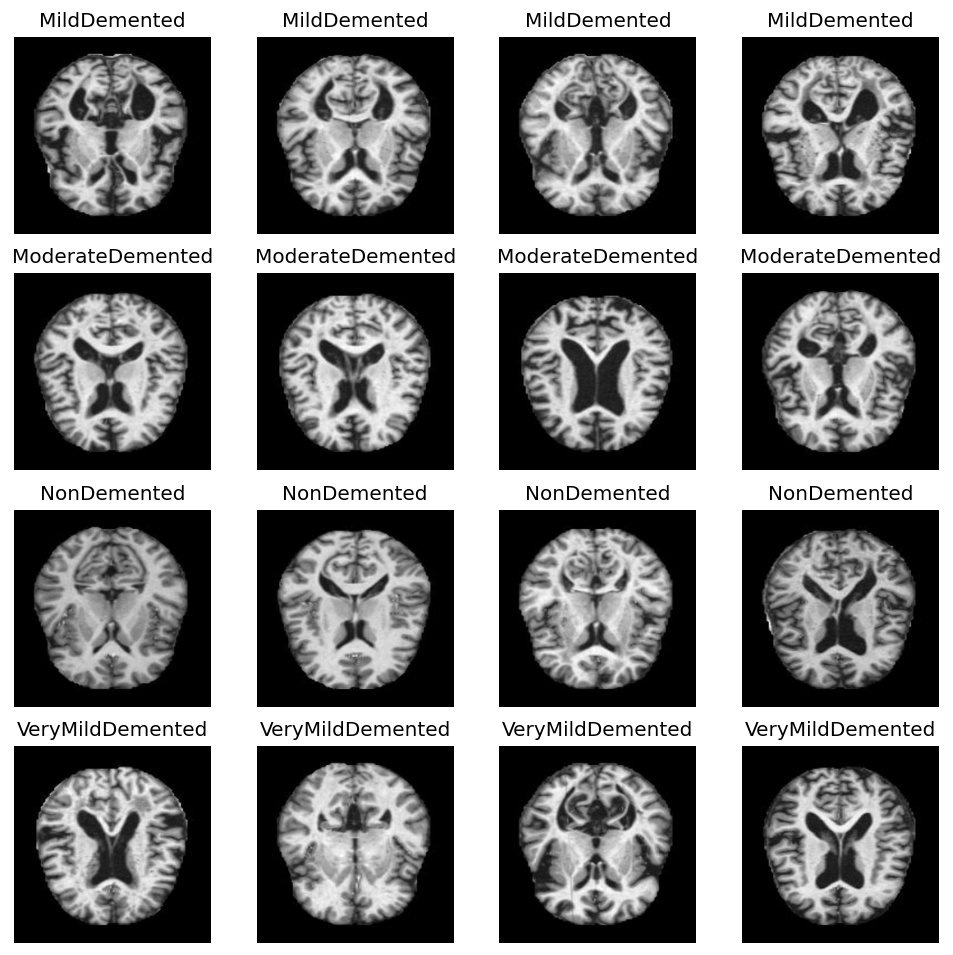

In [11]:
target_labels, printed_labels = [0, 1, 2, 3], []
plt.figure(figsize = (10, 10), dpi = 120)
count = 0

for i in range(len(train_images)):

  if printed_labels.count(train_labels[i]) == 4 and train_labels[i] in target_labels:
    target_labels.remove(train_labels[i])

  if len(target_labels) == 0:
    break
  
  if train_labels[i] in target_labels:
    ax = plt.subplot(4, 4, count + 1)
    plt.imshow(train_images[i])
    plt.axis(False)
    plt.title(class_names[train_labels[i]])
    printed_labels.append(train_labels[i])
    count += 1

--- As the images above suggest, images has been read successfully from the directory. Thus, the exact same method is being used for the test set.

--- An important thing that these images depict, is that it might be hard to distinguish image of class 'ModerateDemented' from some other classes by eye, as there is some similarities. Note that the number of samples in the afformentioned class is critically lower than other classes, the importance of solving the imbalanced classes issue is more comprehendible.

In [12]:
test_images_dir = []

for label in class_names:
  test_images_dir.append(list(test_dir.glob(f'{label}/*')))

for i in range(len(class_names)):
  print(f'{class_names[i]} : {len(test_images_dir[i])}')

MildDemented : 179
ModerateDemented : 12
NonDemented : 640
VeryMildDemented : 448


In [13]:
images_dict = dict(zip(class_names, test_images_dir))

test_images, test_labels = [], []
for key in images_dict:
  for path in images_dict[key]:
    image = cv2.resize(cv2.imread(str(path)), (240, 240))
    test_images.append(image)
    test_labels.append(class_names.index(key))

test_images = np.array(test_images)
test_labels = np.array(test_labels)

test_images.shape, test_labels.shape

((1279, 240, 240, 3), (1279,))

## Handling Imbalanced Classes Issue

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.15, shuffle = True, random_state = 1)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4352, 240, 240, 3), (769, 240, 240, 3), (4352,), (769,))

In [15]:
labels, counts = np.unique(y_train, return_counts = True)

for i in range(len(labels)):
  print(f'{labels[i]} : {counts[i]}')

0 : 614
1 : 45
2 : 2164
3 : 1529


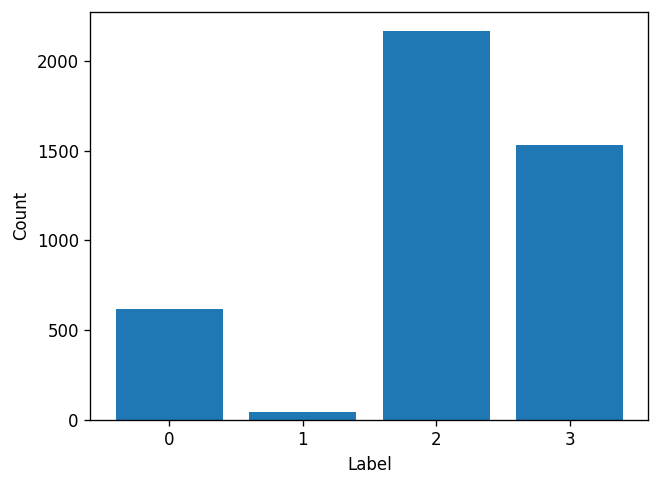

In [16]:
plt.figure(figsize = (6, 4.5), dpi = 120)
plt.bar(labels, counts)
plt.xticks(labels)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

--- As the difference between the number of samples of classes 2 and 3 is not significant, especially in comaprison with the two other classes, augmentation techniques are being applied to the samples of classes 0 and 1.

--- Comparing the number of samples, I believe that for class 0, 2 new samples must be derived from each original image. On the other hand, for class 1, 33 samples should be created from each image to reach at least 1500 samples in total.

In [17]:
aug_net = keras.Sequential([
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomFlip(),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.4)
])

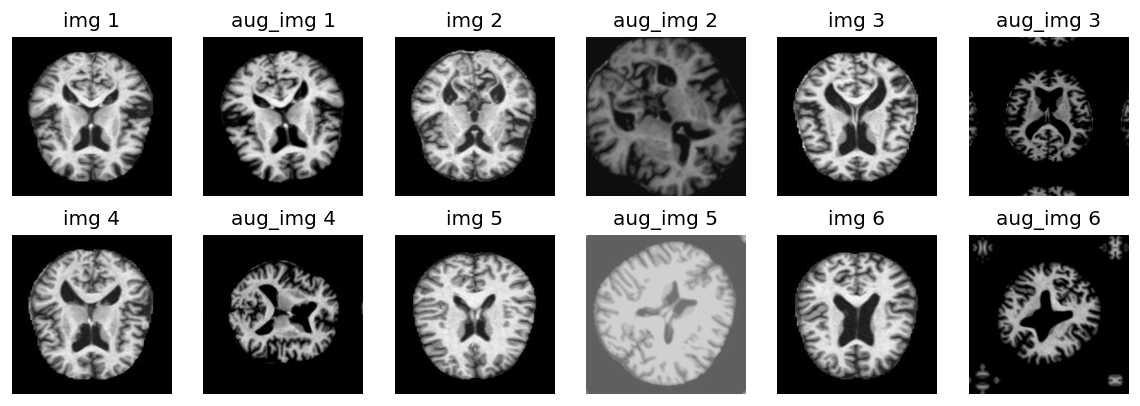

In [18]:
plt.figure(figsize = (12, 4), dpi = 120)
count = 0
for i in range(6):

  index = random.randint(0, len(X_train))

  ax = plt.subplot(2, 6, count + 1)
  plt.imshow(X_train[index])
  plt.axis(False)
  plt.title(f'img {i + 1}')

  ax = plt.subplot(2, 6, count + 2)
  aug_img = aug_net(X_train[index])
  plt.imshow(aug_img.numpy().astype('uint8'))
  plt.axis(False)
  plt.title(f'aug_img {i + 1}')

  count += 2

--- Putting the augmentation NN into tests, it performed well enough, and it is also stable. Thus, this NN is being used for deriving images from the original ones.

In [19]:
aug_images_class_0, aug_images_class_1 = [], []
for i in range(len(y_train)):

  if y_train[i] == 0:
    for rep in range(2):
      aug_img = aug_net(X_train[i])
      aug_images_class_0.append(aug_img.numpy().astype('uint8'))



  if y_train[i] == 1:
    for rep in range(33):
      aug_img = aug_net(X_train[i])
      aug_images_class_1.append(aug_img.numpy().astype('uint8'))

aug_images_class_0 = np.array(aug_images_class_0)
aug_images_class_1 = np.array(aug_images_class_1)

aug_images_class_0.shape, aug_images_class_1.shape

((1228, 240, 240, 3), (1485, 240, 240, 3))

In [20]:
y_aug_class_0 = np.zeros(shape = (1228,)).astype(int)
y_aug_class_1 = np.ones(shape = (1485,)).astype(int)

In [21]:
aug_images = np.vstack((aug_images_class_0, aug_images_class_1))
aug_labels = np.hstack((y_aug_class_0, y_aug_class_1))

aug_images.shape, aug_labels.shape

((2713, 240, 240, 3), (2713,))

--- Now for retaining our ability to perform trial-error process, the original train images and labels will not change, but new sets will be defined that consist both original and derived images and thier labels.

In [22]:
X_train_aug = np.vstack((X_train, aug_images))
y_train_aug = np.hstack((y_train, aug_labels))

X_train.shape, y_train.shape, X_train_aug.shape, y_train_aug.shape

((4352, 240, 240, 3), (4352,), (7065, 240, 240, 3), (7065,))

In [23]:
labels, counts = np.unique(y_train_aug, return_counts = True)

for i in range(len(labels)):
  print(f'{labels[i]} : {counts[i]}')

0 : 1842
1 : 1530
2 : 2164
3 : 1529


--- In the recently defined sets, the difference between the number of samples in each class with others is relatively lower than the original sets.

In [24]:
# shuffling both images and labels in the exact same order.
shuffler = np.random.permutation(len(y_train_aug))

X_train_aug = X_train_aug[shuffler]
y_train_aug = y_train_aug[shuffler]

## Training CNNs

In [15]:
def plot_training_curves(history_df):
  plt.figure(figsize = (13, 4), dpi = 120)
  ax = plt.subplot(1, 2, 1)
  plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
  plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.legend()
  plt.grid()
  ax = plt.subplot(1, 2, 2)
  plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
  plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accuracy') 
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid()
  plt.show()

In [30]:
# initial model that is being trained using original images with imbalanced class distribution
tf.random.set_seed(42)

cnn_1 = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_1.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_1 = cnn_1.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val))

Epoch 1/30
136/136 [==============================] - 4s 25ms/step - loss: 1401.4686 - accuracy: 0.5009 - val_loss: 56.1517 - val_accuracy: 0.4564
Epoch 2/30
136/136 [==============================] - 3s 23ms/step - loss: 48.0813 - accuracy: 0.6190 - val_loss: 20.9648 - val_accuracy: 0.5488
Epoch 3/30
136/136 [==============================] - 3s 23ms/step - loss: 4.4262 - accuracy: 0.7748 - val_loss: 1.8336 - val_accuracy: 0.7776
Epoch 4/30
136/136 [==============================] - 3s 23ms/step - loss: 0.4782 - accuracy: 0.9131 - val_loss: 0.8746 - val_accuracy: 0.8765
Epoch 5/30
136/136 [==============================] - 3s 23ms/step - loss: 0.1210 - accuracy: 0.9692 - val_loss: 0.6087 - val_accuracy: 0.9077
Epoch 6/30
136/136 [==============================] - 3s 23ms/step - loss: 0.0355 - accuracy: 0.9892 - val_loss: 0.6464 - val_accuracy: 0.9090
Epoch 7/30
136/136 [==============================] - 3s 23ms/step - loss: 0.0867 - accuracy: 0.9763 - val_loss: 0.8140 - val_accuracy: 

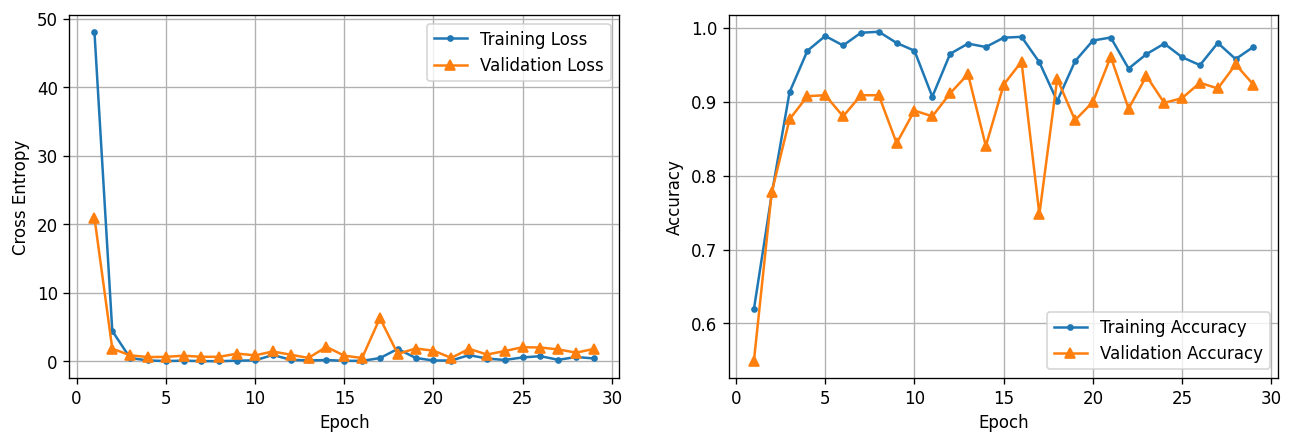

In [31]:
plot_training_curves(pd.DataFrame(history_1.history).iloc[1:,:])

In [32]:
# initial model being trained using augmented images with balanced class distribution
tf.random.set_seed(42)

cnn_1_a = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_1_a.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_1_a = cnn_1_a.fit(X_train_aug, y_train_aug, epochs = 30, validation_data = (X_val, y_val))

Epoch 1/30
221/221 [==============================] - 6s 25ms/step - loss: 1199.9393 - accuracy: 0.5227 - val_loss: 3.4834 - val_accuracy: 0.7282
Epoch 2/30
221/221 [==============================] - 5s 23ms/step - loss: 3.2003 - accuracy: 0.7462 - val_loss: 4.9010 - val_accuracy: 0.6801
Epoch 3/30
221/221 [==============================] - 5s 23ms/step - loss: 1.2973 - accuracy: 0.8542 - val_loss: 1.0118 - val_accuracy: 0.8765
Epoch 4/30
221/221 [==============================] - 5s 23ms/step - loss: 0.7852 - accuracy: 0.9036 - val_loss: 1.4200 - val_accuracy: 0.8843
Epoch 5/30
221/221 [==============================] - 5s 23ms/step - loss: 0.8619 - accuracy: 0.9097 - val_loss: 1.9083 - val_accuracy: 0.8518
Epoch 6/30
221/221 [==============================] - 5s 23ms/step - loss: 1.0652 - accuracy: 0.9180 - val_loss: 4.8234 - val_accuracy: 0.7789
Epoch 7/30
221/221 [==============================] - 5s 23ms/step - loss: 1.4058 - accuracy: 0.9073 - val_loss: 1.8194 - val_accuracy: 0.8

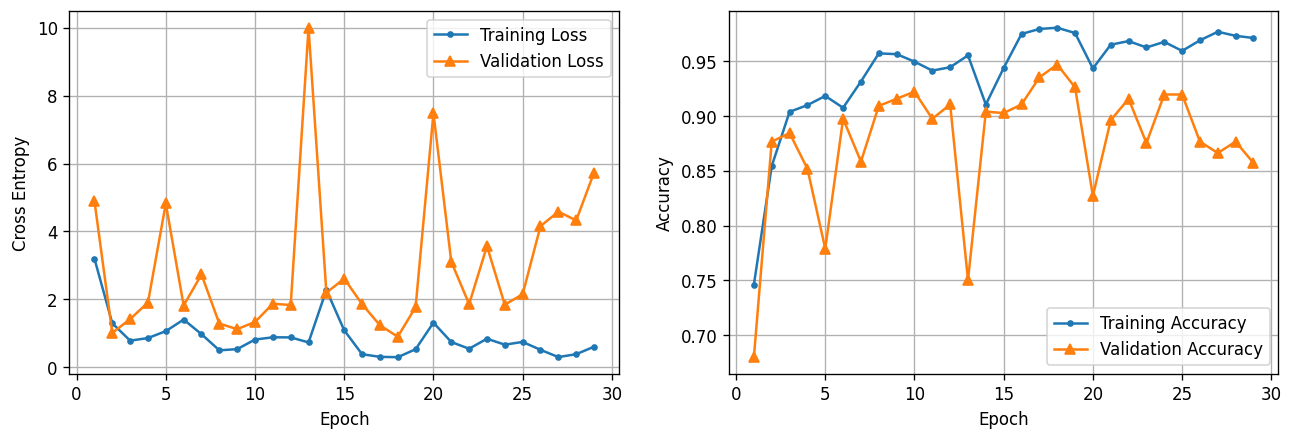

In [33]:
plot_training_curves(pd.DataFrame(history_1_a.history).iloc[1:,:])

--- Comparing the results of the both runs, it seems that using the original data yields more consistency in the results of the training, and so my initial assumption about the imbalanced classes issue is naive. That is to say, the CNN can learn the pattern of the images even for the minority class.

--- Note that the results are not reproudcible as the models are being run on GPU, and so each time a model is being re-run the results might vary to some extent.

--- Considering that using the original data is less computationally extensive, even with minor worse results it is the preferred one for me, as my resources are limited.

In [34]:
y_pred_im = np.argmax(cnn_1.predict(X_val), axis = 1)
y_pred_b = np.argmax(cnn_1_a.predict(X_val), axis = 1)

y_pred_im.shape, y_pred_b.shape

25/25 [==============================] - 0s 8ms/step


((769,), (769,))

In [35]:
print(metrics.classification_report(y_val, y_pred_im))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       103
           1       1.00      0.86      0.92         7
           2       0.98      0.91      0.95       396
           3       0.87      0.93      0.90       263

    accuracy                           0.92       769
   macro avg       0.93      0.91      0.92       769
weighted avg       0.93      0.92      0.92       769



In [36]:
print(metrics.classification_report(y_val, y_pred_b))

              precision    recall  f1-score   support

           0       0.93      0.66      0.77       103
           1       1.00      0.71      0.83         7
           2       0.81      0.99      0.89       396
           3       0.95      0.73      0.83       263

    accuracy                           0.86       769
   macro avg       0.92      0.78      0.83       769
weighted avg       0.87      0.86      0.85       769



--- Comparing the models on the minority class, using the origial set of images is probably the better approach here.

In [17]:
tf.random.set_seed(42)

cnn_2 = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_2.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_2 = cnn_2.fit(X_train, y_train, epochs = 20, validation_data = (X_val, y_val))

Epoch 1/20
136/136 [==============================] - 19s 75ms/step - loss: 7770.2700 - accuracy: 0.5358 - val_loss: 9.6443 - val_accuracy: 0.7516
Epoch 2/20
136/136 [==============================] - 9s 70ms/step - loss: 6.8124 - accuracy: 0.8201 - val_loss: 6.0064 - val_accuracy: 0.8218
Epoch 3/20
136/136 [==============================] - 9s 70ms/step - loss: 4.8586 - accuracy: 0.8796 - val_loss: 10.9078 - val_accuracy: 0.7971
Epoch 4/20
136/136 [==============================] - 9s 69ms/step - loss: 2.3548 - accuracy: 0.9315 - val_loss: 15.8010 - val_accuracy: 0.7763
Epoch 5/20
136/136 [==============================] - 10s 70ms/step - loss: 3.6778 - accuracy: 0.9221 - val_loss: 5.8751 - val_accuracy: 0.8869
Epoch 6/20
136/136 [==============================] - 9s 69ms/step - loss: 3.2957 - accuracy: 0.9341 - val_loss: 5.1366 - val_accuracy: 0.9116
Epoch 7/20
136/136 [==============================] - 9s 69ms/step - loss: 2.0365 - accuracy: 0.9612 - val_loss: 3.1886 - val_accuracy:

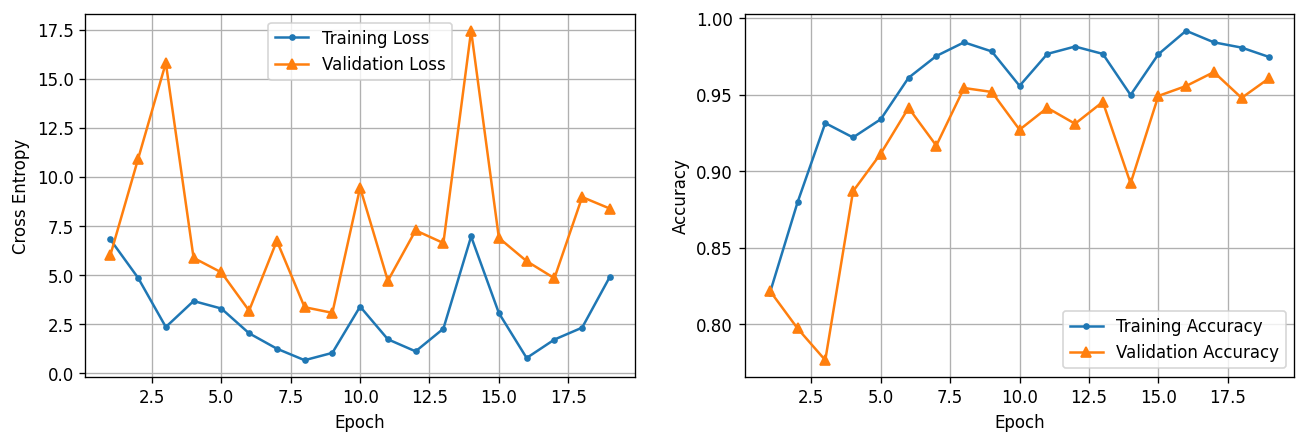

In [18]:
plot_training_curves(pd.DataFrame(history_2.history).iloc[1:,:])

--- Adding more hidden units to the only Dense layer of the model worsens the model regarding loss!!!

In [19]:
tf.random.set_seed(42)

cnn_3 = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_3.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_3 = cnn_3.fit(X_train, y_train, epochs = 20, validation_data = (X_val, y_val))

Epoch 1/20
136/136 [==============================] - 5s 33ms/step - loss: 303.6248 - accuracy: 0.5145 - val_loss: 0.8161 - val_accuracy: 0.6177
Epoch 2/20
136/136 [==============================] - 4s 31ms/step - loss: 0.6722 - accuracy: 0.7132 - val_loss: 0.6373 - val_accuracy: 0.7074
Epoch 3/20
136/136 [==============================] - 4s 31ms/step - loss: 0.3629 - accuracy: 0.8509 - val_loss: 0.3677 - val_accuracy: 0.8648
Epoch 4/20
136/136 [==============================] - 4s 31ms/step - loss: 0.1944 - accuracy: 0.9253 - val_loss: 0.2956 - val_accuracy: 0.8791
Epoch 5/20
136/136 [==============================] - 4s 32ms/step - loss: 0.1516 - accuracy: 0.9455 - val_loss: 0.2824 - val_accuracy: 0.8882
Epoch 6/20
136/136 [==============================] - 4s 31ms/step - loss: 0.1150 - accuracy: 0.9593 - val_loss: 0.3509 - val_accuracy: 0.8882
Epoch 7/20
136/136 [==============================] - 4s 31ms/step - loss: 0.0639 - accuracy: 0.9782 - val_loss: 0.3026 - val_accuracy: 0.90

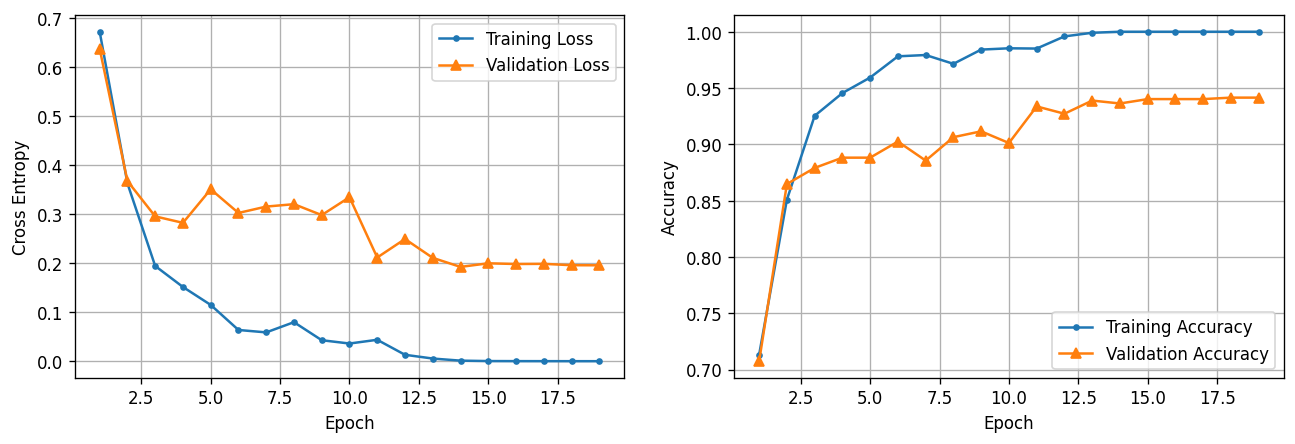

In [20]:
plot_training_curves(pd.DataFrame(history_3.history).iloc[1:,:])

--- Expanding the convolution part of the network improved the model significantly in terms of loss and consistency. However, the best value for the validation accuracy is not as good as the first model. Regaarding that the results are not reproducible, I believe that consistency is more improtant that the value of the exterme points on the plots. 

In [22]:
y_pred = np.argmax(cnn_3.predict(X_val), axis = 1)
print(metrics.classification_report(y_val, y_pred))

25/25 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       103
           1       1.00      1.00      1.00         7
           2       0.96      0.96      0.96       396
           3       0.93      0.93      0.93       263

    accuracy                           0.94       769
   macro avg       0.95      0.95      0.95       769
weighted avg       0.94      0.94      0.94       769



--- The results above are quite satisfactory, but it seems the still there is room for improvement.

In [24]:
tf.random.set_seed(42)

cnn_4 = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_4.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_4 = cnn_4.fit(X_train, y_train, epochs = 40, validation_data = (X_val, y_val))

Epoch 1/40
136/136 [==============================] - 6s 43ms/step - loss: 572.3005 - accuracy: 0.5177 - val_loss: 0.8115 - val_accuracy: 0.6398
Epoch 2/40
136/136 [==============================] - 6s 41ms/step - loss: 0.6468 - accuracy: 0.7339 - val_loss: 0.7060 - val_accuracy: 0.7139
Epoch 3/40
136/136 [==============================] - 6s 41ms/step - loss: 0.3232 - accuracy: 0.8789 - val_loss: 0.2995 - val_accuracy: 0.8856
Epoch 4/40
136/136 [==============================] - 6s 41ms/step - loss: 0.1568 - accuracy: 0.9423 - val_loss: 0.3253 - val_accuracy: 0.8752
Epoch 5/40
136/136 [==============================] - 6s 41ms/step - loss: 0.0762 - accuracy: 0.9729 - val_loss: 0.2442 - val_accuracy: 0.9116
Epoch 6/40
136/136 [==============================] - 6s 41ms/step - loss: 0.0459 - accuracy: 0.9844 - val_loss: 0.9249 - val_accuracy: 0.7867
Epoch 7/40
136/136 [==============================] - 6s 42ms/step - loss: 0.1499 - accuracy: 0.9488 - val_loss: 0.2795 - val_accuracy: 0.90

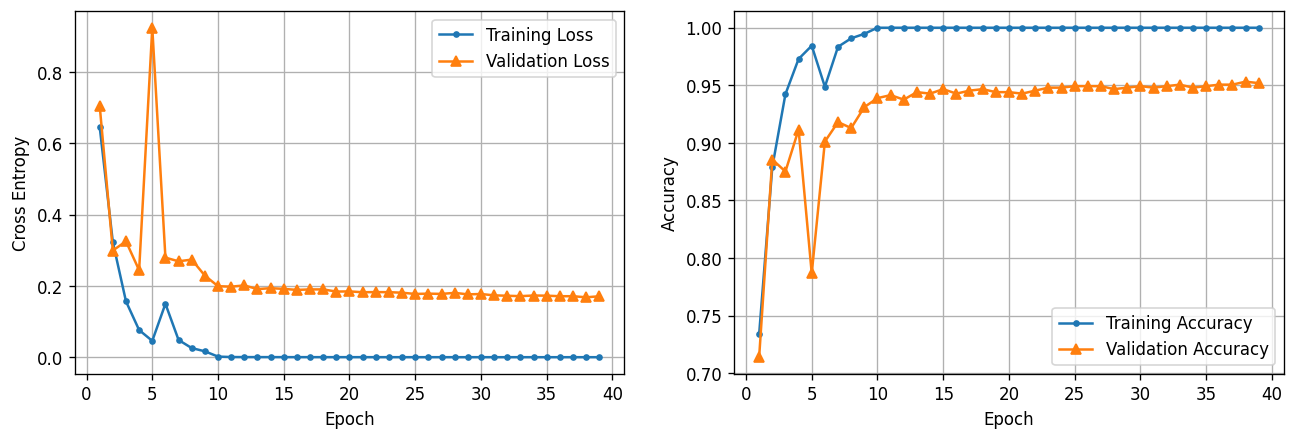

In [25]:
plot_training_curves(pd.DataFrame(history_4.history).iloc[1:,:])

--- Increasing the number of units in the Dense layer, and increasig the number of epochs as well have minor positive impact on the model. The loss is at its lowest up to now, and the accuracy is better than the previous model.

In [26]:
y_pred = np.argmax(cnn_4.predict(X_val), axis = 1)
print(metrics.classification_report(y_val, y_pred))

25/25 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       103
           1       1.00      1.00      1.00         7
           2       0.94      0.97      0.95       396
           3       0.95      0.94      0.94       263

    accuracy                           0.95       769
   macro avg       0.97      0.96      0.96       769
weighted avg       0.95      0.95      0.95       769



In [27]:
tf.random.set_seed(42)

cnn_5 = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_5.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_5 = cnn_5.fit(X_train, y_train, epochs = 40, validation_data = (X_val, y_val))

Epoch 1/40
136/136 [==============================] - 7s 42ms/step - loss: 108.0985 - accuracy: 0.4802 - val_loss: 0.9666 - val_accuracy: 0.5345
Epoch 2/40
136/136 [==============================] - 6s 40ms/step - loss: 0.9522 - accuracy: 0.5588 - val_loss: 0.9230 - val_accuracy: 0.5631
Epoch 3/40
136/136 [==============================] - 5s 40ms/step - loss: 0.8719 - accuracy: 0.6124 - val_loss: 0.8619 - val_accuracy: 0.5969
Epoch 4/40
136/136 [==============================] - 5s 40ms/step - loss: 0.7889 - accuracy: 0.6590 - val_loss: 0.8036 - val_accuracy: 0.6580
Epoch 5/40
136/136 [==============================] - 6s 40ms/step - loss: 0.6752 - accuracy: 0.7165 - val_loss: 0.7398 - val_accuracy: 0.6853
Epoch 6/40
136/136 [==============================] - 6s 41ms/step - loss: 0.5146 - accuracy: 0.7902 - val_loss: 0.7379 - val_accuracy: 0.7022
Epoch 7/40
136/136 [==============================] - 5s 40ms/step - loss: 0.3787 - accuracy: 0.8490 - val_loss: 0.6810 - val_accuracy: 0.74

--- Expanding the convolution part once more did not have the positive effect that I've been looking for. Thus, the convolution part will remain intact from the model 4, and other parts will go for trial and error process.

In [29]:
tf.random.set_seed(42)

cnn_6 = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.RandomFlip(),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_6.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_6 = cnn_6.fit(X_train, y_train, epochs = 40, validation_data = (X_val, y_val))

Epoch 1/40
136/136 [==============================] - 10s 66ms/step - loss: 497.9358 - accuracy: 0.4694 - val_loss: 1.0169 - val_accuracy: 0.5254
Epoch 2/40
136/136 [==============================] - 9s 63ms/step - loss: 1.0158 - accuracy: 0.5299 - val_loss: 0.9988 - val_accuracy: 0.5410
Epoch 3/40
136/136 [==============================] - 9s 69ms/step - loss: 0.9935 - accuracy: 0.5358 - val_loss: 0.9569 - val_accuracy: 0.5709
Epoch 4/40
136/136 [==============================] - 9s 64ms/step - loss: 0.9599 - accuracy: 0.5561 - val_loss: 0.9458 - val_accuracy: 0.5410
Epoch 5/40
136/136 [==============================] - 9s 63ms/step - loss: 0.9366 - accuracy: 0.5710 - val_loss: 0.9543 - val_accuracy: 0.5592
Epoch 6/40
136/136 [==============================] - 9s 63ms/step - loss: 0.9034 - accuracy: 0.5947 - val_loss: 0.9796 - val_accuracy: 0.5657
Epoch 7/40
136/136 [==============================] - 9s 64ms/step - loss: 0.8884 - accuracy: 0.5965 - val_loss: 0.9533 - val_accuracy: 0.5

--- Adding augmentation layers seems of no help with acheiving better results!

In [18]:
tf.random.set_seed(42)

cnn_7 = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_7.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_7 = cnn_7.fit(X_train, y_train, epochs = 40, validation_data = (X_val, y_val))

Epoch 1/40
136/136 [==============================] - 7s 46ms/step - loss: 383.0548 - accuracy: 0.4802 - val_loss: 0.9737 - val_accuracy: 0.5722
Epoch 2/40
136/136 [==============================] - 6s 43ms/step - loss: 0.9503 - accuracy: 0.5602 - val_loss: 0.9033 - val_accuracy: 0.5839
Epoch 3/40
136/136 [==============================] - 6s 43ms/step - loss: 0.8557 - accuracy: 0.6140 - val_loss: 0.8473 - val_accuracy: 0.6034
Epoch 4/40
136/136 [==============================] - 6s 44ms/step - loss: 0.7941 - accuracy: 0.6390 - val_loss: 0.7875 - val_accuracy: 0.6489
Epoch 5/40
136/136 [==============================] - 6s 43ms/step - loss: 0.7183 - accuracy: 0.6756 - val_loss: 0.7224 - val_accuracy: 0.6775
Epoch 6/40
136/136 [==============================] - 6s 43ms/step - loss: 0.6823 - accuracy: 0.7011 - val_loss: 0.6962 - val_accuracy: 0.6788
Epoch 7/40
136/136 [==============================] - 6s 44ms/step - loss: 0.5936 - accuracy: 0.7486 - val_loss: 0.7111 - val_accuracy: 0.69

--- Adding dropout layer had an adverse effect on the model, and considring that overfitting has not been a problem with this data, it is sensible that none of the dropout and augmentation layers could help with better results.

In [23]:
tf.random.set_seed(42)

cnn_8 = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_8.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(lr = 0.002),
    metrics = 'accuracy'
)

history_8 = cnn_8.fit(X_train, y_train, epochs = 40, validation_data = (X_val, y_val))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
136/136 [==============================] - 53s 385ms/step - loss: 888.9787 - accuracy: 0.4729 - val_loss: 0.9741 - val_accuracy: 0.5592
Epoch 2/40
136/136 [==============================] - 6s 42ms/step - loss: 0.9676 - accuracy: 0.5517 - val_loss: 0.9444 - val_accuracy: 0.5605
Epoch 3/40
136/136 [==============================] - 6s 43ms/step - loss: 0.8676 - accuracy: 0.6036 - val_loss: 0.9137 - val_accuracy: 0.5657
Epoch 4/40
136/136 [==============================] - 6s 42ms/step - loss: 0.7594 - accuracy: 0.6611 - val_loss: 0.8771 - val_accuracy: 0.6138
Epoch 5/40
136/136 [==============================] - 6s 42ms/step - loss: 0.6391 - accuracy: 0.7238 - val_loss: 0.9554 - val_accuracy: 0.6008
Epoch 6/40
136/136 [==============================] - 6s 43ms/step - loss: 0.5275 - accuracy: 0.7785 - val_loss: 1.0288 - val_accuracy: 0.6164
Epoch 7/40
136/136 [==============================] - 6s 42ms/step - loss: 0.4153 - accuracy: 0.8281 - val_loss: 0.9856 - val_accuracy: 0.

--- Not even increasing the learning rate can improve the model!

--- This structure is being trained for more epochs with default learning rate to see if the results improve overtime.

In [24]:
tf.random.set_seed(42)

cnn_9 = keras.Sequential([
    layers.Rescaling(1/.255),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

cnn_9.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_9 = cnn_9.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val))

Epoch 1/100
136/136 [==============================] - 7s 45ms/step - loss: 572.2996 - accuracy: 0.5193 - val_loss: 0.8139 - val_accuracy: 0.6359
Epoch 2/100
136/136 [==============================] - 6s 42ms/step - loss: 0.6455 - accuracy: 0.7353 - val_loss: 0.6895 - val_accuracy: 0.7217
Epoch 3/100
136/136 [==============================] - 6s 42ms/step - loss: 0.3152 - accuracy: 0.8830 - val_loss: 0.3070 - val_accuracy: 0.8778
Epoch 4/100
136/136 [==============================] - 6s 43ms/step - loss: 0.1298 - accuracy: 0.9568 - val_loss: 0.2956 - val_accuracy: 0.8882
Epoch 5/100
136/136 [==============================] - 6s 43ms/step - loss: 0.0636 - accuracy: 0.9766 - val_loss: 0.2311 - val_accuracy: 0.9181
Epoch 6/100
136/136 [==============================] - 6s 43ms/step - loss: 0.0226 - accuracy: 0.9938 - val_loss: 0.2391 - val_accuracy: 0.9207
Epoch 7/100
136/136 [==============================] - 6s 43ms/step - loss: 0.0165 - accuracy: 0.9959 - val_loss: 0.1726 - val_accurac

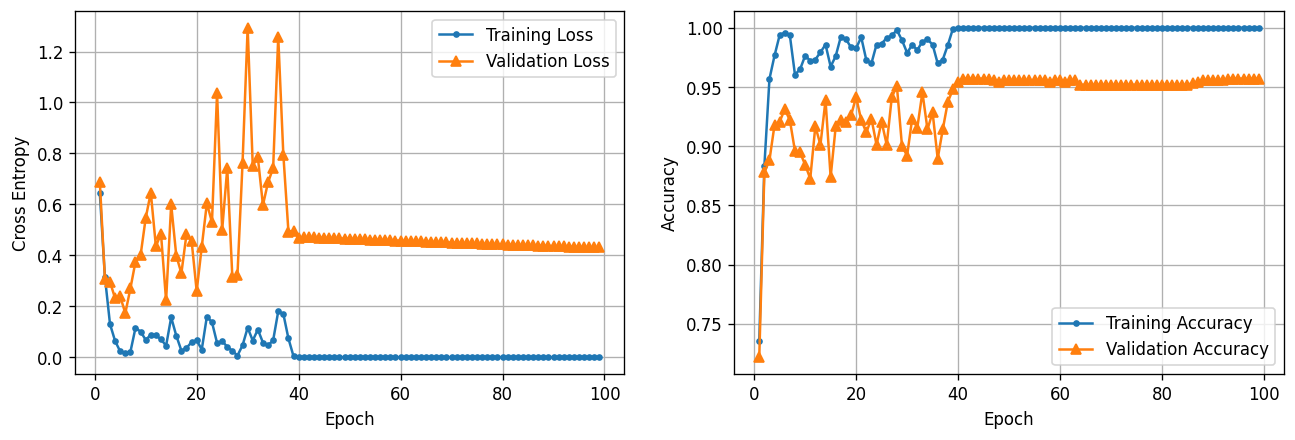

In [25]:
plot_training_curves(pd.DataFrame(history_9.history).iloc[1:,:])

In [26]:
y_pred = np.argmax(cnn_9.predict(X_val), axis = 1)
print(metrics.classification_report(y_val, y_pred))

25/25 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       103
           1       1.00      1.00      1.00         7
           2       0.95      0.98      0.97       396
           3       0.96      0.94      0.95       263

    accuracy                           0.96       769
   macro avg       0.97      0.96      0.96       769
weighted avg       0.96      0.96      0.96       769



--- By increasing the number of epoch, the model improved slightly, and it seems that it can get better by each iteration after certain epochs. However, regarding the randomness that is the nature of NNs and GPUs, the loss flactutated around 0.4, while in the previous run of the very same model, the loss was about 0.2. 

--- All in all, because of the consistency of the results, I believe that this structure can be the final one, and saving the best model based on the metrics of each epoch from a considerably large number of epochs, might be the best possible approach.